In [1]:
%load_ext autoreload
%autoreload 2
# Set-up: Import numpy and assign GPU
from collections import defaultdict
import os
import numpy as np
import scipy as sp
import seaborn as sns
import sklearn
from tqdm.notebook import tqdm

from gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('1')

Using GPU:1


In [2]:
# Load Amazon WILDS pre-trained model
import statistics
import sys
import pickle
import numpy as np
import pandas as pd

import torch
import torchvision.transforms as transforms

import argparse
import pdb

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from transforms_helenl import initialize_transform, getBertTokenizer

sys.path.insert(0, './wilds/examples/')
from algorithms.initializer import initialize_algorithm


In [3]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_seed(0)

In [4]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
#config_dict = pickle.load(open('amazon_config.txt', 'rb'))



full_dataset = get_dataset(dataset='civilcomments', download=False, root_dir = './wilds/data')

In [5]:
def predict_augmented_labels(transform_name):
    
    # Grab config generated by WILDS library from txt file
    infile = open('civilcomments_config.txt','rb')
    new_dict = vars(pickle.load(infile))
    infile.close() 

    # Modify config with intended transformation
    new_dict['transform'] = transform_name

    # Create config with ERM algorithm
    config = Namespace(**new_dict)
    config.algorithm = 'ERM'

    
    # Generate training and evaluation transforms
    train_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=True)
    eval_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=False)
    
    
    # Prepare training data, loader, and grouper
    train_data = full_dataset.get_subset('train', transform=train_transform)
    train_loader = get_train_loader('standard', train_data, batch_size=64)
    train_grouper = CombinatorialGrouper(dataset=full_dataset, groupby_fields=config.groupby_fields)
    
        # Prepare training data, loader, and grouper
        
    eval_data = full_dataset.get_subset('test', transform=eval_transform)
    eval_loader = get_eval_loader('standard', eval_data, batch_size = 64)
    
    # CODE TAKEN FROM WILDS TRAINING SCRIPTS:
    datasets = defaultdict(dict)
    for split in full_dataset.split_dict.keys():
        if split=='train':
            transform = train_transform
            verbose = True
        elif split == 'val':
            transform = eval_transform
            verbose = True
        else:
            transform = eval_transform
            verbose = False
        # Get subset
        datasets[split]['dataset'] = full_dataset.get_subset(
            split,
            frac=config.frac,
            transform=transform)

        if split == 'train':
            datasets[split]['loader'] = get_train_loader(
                loader=config.train_loader,
                dataset=datasets[split]['dataset'],
                batch_size=config.batch_size,
                uniform_over_groups=config.uniform_over_groups,
                grouper=train_grouper,
                distinct_groups=config.distinct_groups,
                n_groups_per_batch=config.n_groups_per_batch,
            **config.loader_kwargs)
        else:
            datasets[split]['loader'] = get_eval_loader(
                loader=config.eval_loader,
                dataset=datasets[split]['dataset'],
                grouper=train_grouper,
                batch_size=config.batch_size,
                **config.loader_kwargs)

    # Set fields
    datasets[split]['split'] = split
    datasets[split]['name'] = full_dataset.split_names[split]
    datasets[split]['verbose'] = verbose

    # Loggers
    # datasets[split]['eval_logger'] = BatchLogger(
    #     os.path.join(config.log_dir, f'{split}_eval.csv'), mode=mode, use_wandb=(config.use_wandb and verbose))
    # datasets[split]['algo_logger'] = BatchLogger(
    #     os.path.join(config.log_dir, f'{split}_algo.csv'), mode=mode, use_wandb=(config.use_wandb and verbose))

    print(transform_name)
    print("initialize model")
    # Initiate model and run on training set
    model = initialize_algorithm(config, datasets, train_grouper)
    model.model.cuda()
    
    print("initialization complete")
    
    
    print("generating predictions")
    it = iter(eval_loader)
    predictions = []
    true_values = []
    
    for batch in tqdm(it):
        
        #pdb.set_trace()
        raw_pred = model.model(batch[0].cuda()).cpu().detach().numpy().tolist()
        #softmax_prediction = sp.special.softmax(raw_pred.cpu().detach().numpy()).tolist()
        predictions.append(raw_pred)
        true_values.extend(batch[1].tolist())
    

    print("writing predictions")
    file_name = './ERM_predictions/' + transform_name + ".npy"
    
    with open(file_name, 'wb+') as file:
        np.save(file, predictions)
        np.save(file, true_values)



In [10]:
def calculate_accuracy(prediction_file):
    logit_predictions = []
    labels = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file, allow_pickle = True)
        labels = np.load(file, allow_pickle = True)
    
    '''
    print(len(logit_predictions[0]))
    print(type(logit_predictions))
    print(logit_predictions)
    '''
    
    softmaxed_predictions = []
    
    for pred in logit_predictions[0]:
        softmax = sp.special.softmax(pred).tolist()
        softmaxed_predictions.append(softmax[1])
        
    #plt.hist(logit_predictions)
    #plt.hist(softmaxed_predictions)
    
    #return sklearn.metrics.roc_auc_score(labels[:64], softmaxed_predictions)

    classified_predictions = []
    for prediction in logit_predictions:
        index_prediction = np.argmax(prediction, axis = 1).tolist()
        
        classified_predictions.extend(index_prediction)
    
    unique, counts = np.unique(np.array(classified_predictions), return_counts = True)
    print(unique, counts)
    print(len(labels))
        
    print("PREDICTIONS:", len(classified_predictions))
    #print("PREDICTIONS SAMPLE:", classified_predictions[0])
    print("TRUE VALUES:", len(labels))
    #print("TRUE VALUES SAMPLE:", len(labels[0]))
    #print(type(true_values))
    
    score = sklearn.metrics.accuracy_score(labels, classified_predictions)
    return score

In [11]:
def calculate_recall(prediction_file):
    logit_predictions = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file)
        true_values = np.load(file)
        
    print(true_values)
    classified_predictions = []
    for prediction in logit_predictions:
        if prediction[0][0] > prediction[0][1]:
            classified_predictions.append(0)
            
        else:
            classified_predictions.append(1)
    
    score = sklearn.metrics.recall_score(true_values, classified_predictions)
    return score

In [8]:
predict_augmented_labels('bert')

bert
initialize model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertClassifier: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN t

initialization complete
generating predictions


  0%|          | 0/2091 [00:00<?, ?it/s]

writing predictions


/local/helenl/.conda/envs/tta/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

calculate_accuracy('./ERM_predictions/bert.npy')

[0 1] [ 14589 119193]
133782
PREDICTIONS: 133782
TRUE VALUES: 133782


0.2053116263772406

In [13]:
def plot_prediction_distribution(prediction_file):
    logit_predictions = []
    labels = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file, allow_pickle = True)
        labels = np.load(file, allow_pickle = True)
    
    softmaxed_predictions = []
    
    for pred in logit_predictions[0]:
        softmax = sp.special.softmax(pred).tolist()
        softmaxed_predictions.append(softmax[1])
        
    plt.hist(logit_predictions)
    plt.hist(softmaxed_predictions)
    
    #return sklearn.metrics.roc_auc_score(labels[:64], softmaxed_predictions)

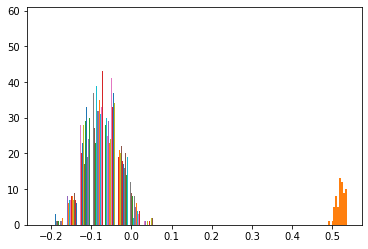

In [14]:
plot_prediction_distribution('./ERM_predictions/bert.npy')

In [21]:
def calculate_roc_auc_score(prediction_file):
    logit_predictions = []
    labels = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file, allow_pickle = True)
        labels = np.load(file, allow_pickle = True)
    
    softmaxed_predictions = []
    
    for batch in logit_predictions:
        for pred in batch:
            softmax = sp.special.softmax(pred).tolist()
            softmaxed_predictions.append(softmax[1])
        
    
    return sklearn.metrics.roc_auc_score(labels, softmaxed_predictions)

In [20]:
calculate_roc_auc_score('./ERM_predictions/bert.npy')

ValueError: Found input variables with inconsistent numbers of samples: [64, 133782]